In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv
/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv


In [60]:
#  Import and read the data 
train = pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/train.csv')
test=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/test.csv')
subm=pd.read_csv('/kaggle/input/kagglexfellowship/kagglex-cohort4/sample_submission.csv')


In [61]:
#Drop the non-beneficial ID columns and assign ID column as labels
def set_index (df):
    df.set_index('id', inplace=True)
    return df

train_df=set_index(train)
test_df=set_index(test)
submission_df=set_index(subm)



In [62]:
# Join the two dataframes on the index
mergedtest_df = test_df.join(submission_df, how='inner')


# Data Exploration

In [63]:
#Determine the number of unique values in each column.
unique_counts = train_df.nunique()
unique_counts

brand             53
model           1827
model_year        34
milage          3212
fuel_type          7
engine          1061
transmission      46
ext_col          260
int_col          124
accident           2
clean_title        1
price           1481
dtype: int64

In [64]:
# Checking the datatypes
train_df.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [65]:
train_df.shape

(54273, 12)

In [66]:
#Lets look for the total number of NaN values for each feature
train_df.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

In [68]:
def price_plot(df):
    plt.figure(figsize=(8, 6))
    sns.stripplot(data=df, y='price', jitter=True, color='purple', alpha=0.5)
    plt.title('Strip Plot: Price Distribution')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


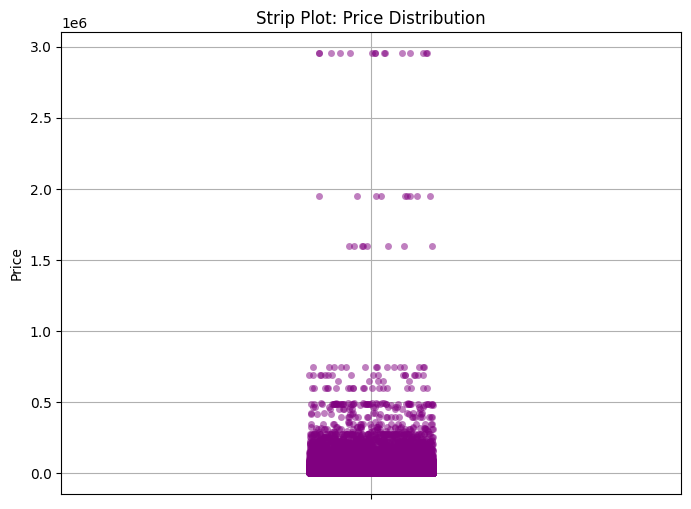

In [69]:
price_plot(train_df)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


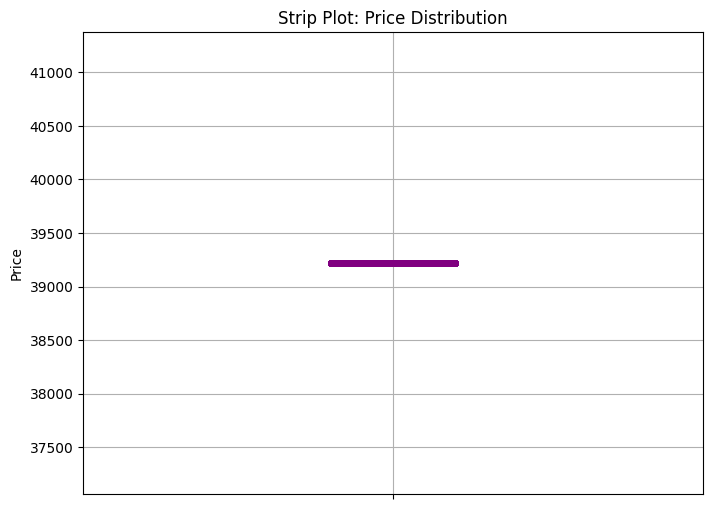

In [70]:
price_plot(mergedtest_df)

Above Histogram shows that most cars lie in the lower range of price.
The above graph has outliers from 0.4 onwards, which need to be removed.

In [ ]:
train_df['price'].describe()

In [ ]:
#identify and remove outliers from the data df in relation to price column using IQR method
Q1 = train_df['price'].quantile(0.25)
Q3 = train_df['price'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
#use IQR value to filter out the outliers
outliersfree_df = train_df[~((train_df['price'] < (Q1 - 1.5 * IQR)) |(train_df['price'] > (Q3 + 0.7 * IQR)))]
outliersfree_df.shape

In [ ]:
plt.figure(figsize=(8, 6))
sns.stripplot(data=outliersfree_df, y='price', jitter=True, color='purple', alpha=0.5)
plt.title('Strip Plot: Price Distribution')
plt.ylabel('Price')
plt.grid(True)
plt.show()

The above plot looks more homogeneous than the previous one after removal of outliers.

# **Data wrangling**

I will reduce the number of features in string data categories, and will remain the numeric categories as they are.

In [ ]:
#Look at brand value counts for binning
brand_counts = outliersfree_df['brand'].value_counts()
brand_counts #keep all car brands 

***Model cleaning***

In [ ]:
# Look at model value counts for binning
model_counts =outliersfree_df['model'].value_counts()
model_counts

In [ ]:
#Reducing the number of car models as a fuature
cutoff_value = 100 #keep if database has 100 and more records of this car model
model_types_to_replace = model_counts[model_counts < cutoff_value].index

# Replace in the dataframe
for model_c in model_types_to_replace:
    outliersfree_df.loc[outliersfree_df['model'] == model_c, 'model'] = "Other"

# Check the updated value counts
model_counts = outliersfree_df['model'].value_counts()
print(model_counts)

**Fuel cleaning**

In [ ]:
# Look at fuel value counts for binning
fuel_counts = outliersfree_df['fuel_type'].value_counts()
fuel_counts

In [ ]:
# Replace '–' with 'Other' in the 'fuel_type' column
outliersfree_df.loc[outliersfree_df['fuel_type'] == '–', 'fuel_type'] = 'Other'
cleaned_train = outliersfree_df[outliersfree_df['fuel_type'] != 'not supported']
fuel_counts = cleaned_train['fuel_type'].value_counts()
fuel_counts

***Engine cleaning***

In [ ]:
# Look at endine value counts for binning
engine_counts = cleaned_train['engine'].value_counts()
engine_counts

In [ ]:
cutoff_value = 100
engine_types_to_replace = engine_counts[engine_counts < cutoff_value].index

# Replace in the dataframe
for engine_c in engine_types_to_replace:
    cleaned_train.loc[cleaned_train['engine'] == engine_c, 'engine'] = "Other"

# Check the updated value counts
engine_counts = cleaned_train['engine'].value_counts()
engine_counts

***Transmission***

In [ ]:
# Look at trans value counts for binning
trans_counts = cleaned_train['transmission'].value_counts()
trans_counts

In [ ]:
cutoff_value = 10
trans_types_to_replace = trans_counts[trans_counts < cutoff_value].index

# Replace in the dataframe
for trans_c in trans_types_to_replace:
    cleaned_train.loc[cleaned_train['transmission'] == trans_c, 'transmission'] = "Other"

# Check the updated value counts
trans_counts = cleaned_train['transmission'].value_counts()
trans_counts

***External colour***

In [ ]:
# Look at colours value counts for binning
ext_col_counts = cleaned_train['ext_col'].value_counts()
ext_col_counts.head(50)

In [ ]:
cutoff_value = 20
ext_col_types_to_replace = ext_col_counts[ext_col_counts < cutoff_value].index

# Replace in the dataframe
for ext_col_c in ext_col_types_to_replace:
    cleaned_train.loc[cleaned_train['ext_col'] == ext_col_c, 'ext_col'] = "Other"

# Check the updated value counts
ext_col_counts = cleaned_train['ext_col'].value_counts()
ext_col_counts

In [ ]:
# Look at colours value counts for binning
int_col_counts = cleaned_train['int_col'].value_counts()
int_col_counts.head(50)

In [ ]:
cleaned_train.loc[cleaned_train['int_col'] == '–', 'int_col'] = 'Other'

In [ ]:
cutoff_value = 10
int_col_types_to_replace = int_col_counts[int_col_counts < cutoff_value].index

# Replace in the dataframe
for int_col_c in int_col_types_to_replace:
    cleaned_train.loc[cleaned_train['int_col'] == int_col_c, 'int_col'] = "Other"

# Check the updated value counts
int_col_counts = cleaned_train['int_col'].value_counts()
int_col_counts

In [ ]:
# Determine the cleaned number of unique values in each column.
unique_counts = cleaned_train.nunique()
unique_counts

In [ ]:
#The last column "Clean_title" is the same "Yes" answer for all rows, that gives no value to analysis. 
#Drop this column.
final_train=cleaned_train.drop(columns=['clean_title'])


In [ ]:
# Display the value counts for each column
for column in final_train.columns:
    value_counts = final_train[column].value_counts()
    print(value_counts)


***Liner Regression***

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Convert categorical data to numeric with `pd.get_dummies`
X = pd.get_dummies(final_train)
X.shape


In [ ]:
# Split our preprocessed data into our features and target arrays
y=X['price'].values.reshape(-1, 1)

In [ ]:
#Removing the price from the prediction features
X = X.drop(['price'], axis=1)


In [ ]:
lm = LinearRegression()
lm.fit(X,y)

In [ ]:
#make predictions
yhat = lm.predict(X)
yhat[0:5]

In [ ]:
#find the intercept
lm.intercept_

In [ ]:
#find the slope
lm.coef_

In [ ]:
#find the MSE
from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(y, yhat)

# Print the MSE
print("Mean Squared Error (MSE):", mse)


In [ ]:
#find the RMSE
rmse = np.sqrt(mse)
rmse

In [ ]:
#find rscore
from sklearn.metrics import r2_score
r2_score(y, yhat)

# Validation with test data

In [ ]:
test_df


In [ ]:
submission_df